In [3]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer


We start by creating a random 1000x1000 matrix A with values extracted from a normal(0,1) distribution. Each row of this matrix is a sample, on the rows we have the features.

In [4]:
A = np.random.normal(0, 1, size=(1000, 1000))

We now need to generate the labels associated with these records. To do so we compute AX + E. To make the matrix computations work, X and E are both of size 1000x50. Values are again extraxted from a normal(0,1) distribution

In [5]:
X = np.random.normal(0, 1, size=(1000, 50))
E = np.random.normal(0, 1, size=(1000, 50))
# execute matrix operations
B = np.matmul(A, X) + E

In [6]:
# to get the class, select biggest value along each row
b = np.argmax(B, axis=1)

A is the matrix of training examples. X is the matrix of parameters. E is a random error added

We define a function for one hot encoding, we will use it later to encode the labels

In [7]:
def one_hot_encode(num_classes, label_vector):

    hot = np.zeros((label_vector.shape[0], num_classes)) # number of examples X number of classes
    hot[np.arange(label_vector.shape[0]), label_vector] = 1 # Element at specified index to 1
    return hot

Here we define function that later will be used to plot our results

In [8]:
def plot_accuracy(cputime_elapsed, accuracy_train):
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    plt.plot(cputime_elapsed, accuracy_train, marker='.', linestyle='-', markersize=3,drawstyle='steps-post')
    plt.title('CPU Time vs Accuracy')
    plt.xlabel('CPU Time')
    plt.ylabel('Accuracy')
    plt.grid(True)  # Add gridlines
    plt.show()

def plot_cost(cputime_elapsed, costs):
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    plt.plot(cputime_elapsed, costs, marker='.', linestyle='-', markersize=3,drawstyle='steps-post')
    plt.title('CPU Time vs cost')
    plt.xlabel('CPU Time')
    plt.ylabel('Cost')
    plt.grid(True)  # Add gridlines
    plt.show()

def plot_all(cputime_elapsed_m, real_time_m, accuracy_train_m, costs_m, methods):

    if len(cputime_elapsed_m) != len(accuracy_train_m) != len(methods) != len(costs_m) != len(real_time_m):
        raise ValueError("Number of methods should match in CPU time matrix, real time matrix, accuracy matrix, costs matrix, and method names list.")

    colors = ['blue', 'red', 'green', 'black', 'orange', 'grey']

    plt.figure(figsize=(12, 5))
    # Plotting
    for i in range(len(cputime_elapsed_m)):
        plt.plot(cputime_elapsed_m[i], accuracy_train_m[i], label=methods[i], color=colors[i], linestyle='-', markersize=3, drawstyle='steps-post')
    plt.xlabel('CPU Time')
    plt.ylabel('Accuracy')
    plt.title('CPU Time vs Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    for i in range(len(cputime_elapsed_m)):
        plt.plot(cputime_elapsed_m[i], costs_m[i], label=methods[i], color=colors[i], linestyle='-', markersize=3, drawstyle='steps-post')
    plt.xlabel('CPU Time')
    plt.ylabel('Cost')
    plt.title('CPU Time vs Cost')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    for i in range(len(real_time_m)):
        plt.plot(real_time_m[i], accuracy_train_m[i], label=methods[i], color=colors[i], linestyle='-', markersize=3, drawstyle='steps-post')
    plt.xlabel('Real Time')
    plt.ylabel('Accuracy')
    plt.title('Real Time vs Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    for i in range(len(real_time_m)):
        plt.plot(real_time_m[i], costs_m[i], label=methods[i], color=colors[i], linestyle='-', markersize=3, drawstyle='steps-post')
    plt.xlabel('Real Time')
    plt.ylabel('Cost')
    plt.title('Real Time vs Cost')
    plt.legend()
    plt.grid(True)
    plt.show()

We also define some helper functions to tidy up the code of the various implementations

In [9]:
# this function executes the matrix operations that are used to compute the gradient, and returns the intermediate values, that are also used to compute
# cost function

def matrix_operations(A, X):
    AX = np.dot(A, X)
    AX -= np.max(AX, axis=1, keepdims=True)  # ->->->->->->->->->subtract the maximum value from each row for numerical stability<-<-<-<-<-<-<-<-<-<-<-<-<
    AX_exp = np.exp(AX)
    sum_AX_exp = np.sum(AX_exp, axis=1, keepdims=True)
    norm_AX_exp = AX_exp / sum_AX_exp
    return AX, AX_exp, sum_AX_exp, norm_AX_exp

In [10]:
# this function simply computes the accuracy based on predictions and true labels

def compute_accuracy(predictions, true_labels):
    correct = np.sum(predictions == true_labels) # count # of correct predictions
    accuracy = correct / len(true_labels) # % of correct predictions
    # print("correct ", correct, "number", len(true_labels))
    return accuracy

We start by implementing a simple gradient descent with fixed stepsize

In [11]:
def gradient_descent(A, B, k, lr=0.0001, train_time = 30, plots=False):

    start_t = time.time()
    start_cputime = time.process_time()

    m, d = A.shape
    X = np.random.normal(0, 1, size=(d, k)) * 0.01

    I = one_hot_encode(k, B) # hot encoding of the labels

    epoch = 0

    cputime_elapsed = []
    real_time_elapsed = []
    accuracy_train = []
    costs = []

    while time.time() - start_t < train_time:
        AX, AX_exp, sum_AX_exp, norm_AX_exp = matrix_operations(A, X)

        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp))
        predictions = np.argmax(norm_AX_exp, axis=1) # compute prediction
        cputime_elapsed.append(time.process_time() - start_cputime)
        real_time_elapsed.append(time.time() - start_t)
        costs.append(cost)
        accuracy_train.append(compute_accuracy(predictions, B)) # compute accuracy

        grad = -np.dot(A.T, I - norm_AX_exp)
        X -= lr * grad

        epoch += 1

    end_cputime = time.process_time()
    cpu_time = end_cputime - start_cputime
    finish_t = time.time()
    t = finish_t - start_t

    if plots == True:
        plot_accuracy(cputime_elapsed, accuracy_train)
        plot_cost(cputime_elapsed, costs)

    return X, cputime_elapsed, accuracy_train, costs, real_time_elapsed

We can test its individual performance: 

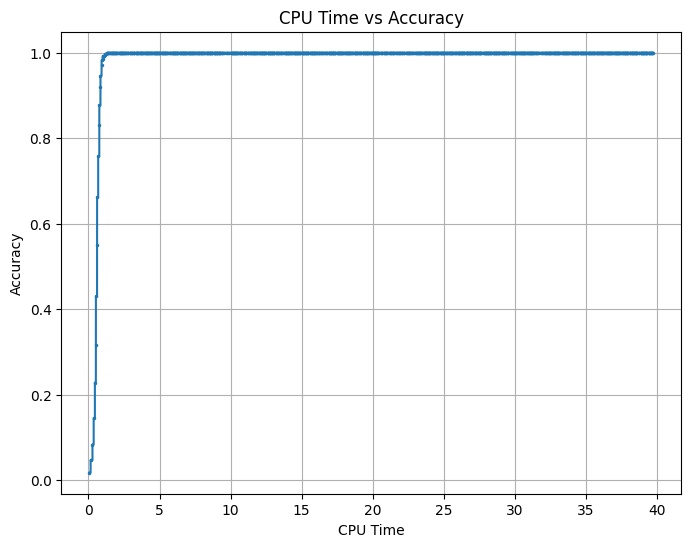

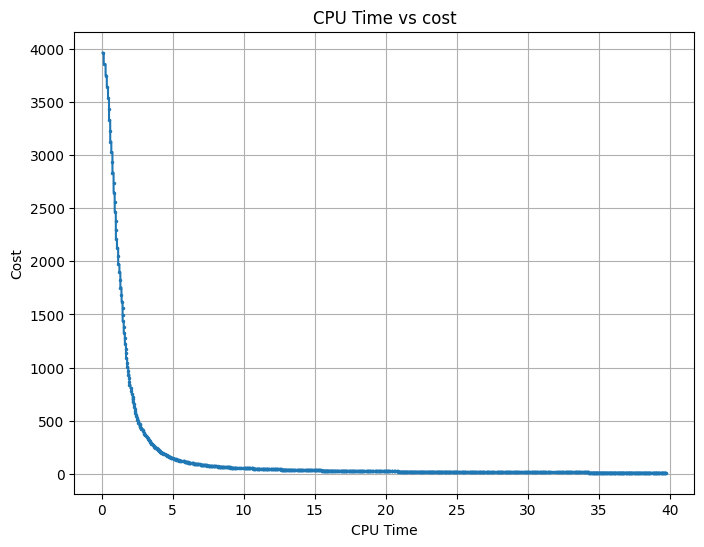

In [13]:
X, cputime_elapsed, accuracy_train, costs, real_time_elapsed = gradient_descent(A, b, k = 50, train_time = 5, plots=True)

We decided to implement the armijo variant. In this way we can estimate a good enough stepsize at each iteration without having to guess it.

In [18]:
def gradient_descent_armijo(A, B, k, delta=0.5, gamma=0.25, step=1, plots=False, train_time = 30, min_alpha = 1e-20):
    start_t = time.time()
    start_cputime = time.process_time()

    t = 1000 * time.time() # current time in milliseconds
    np.random.seed = int(t) % 2**32

    m, d = A.shape
    X = np.random.normal(0, 1, size=(d, k)) * 0.01
    I = one_hot_encode(k, B)

    cputime_elapsed = []
    accuracy_train = []
    costs = []
    real_time_elapsed = []

    epoch = 0
    avg_cost = float('inf')
    while time.time() - start_t < train_time:
        AX, AX_exp, sum_AX_exp, norm_AX_exp = matrix_operations(A, X)
        
        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp))
        predictions = np.argmax(norm_AX_exp, axis=1) # compute prediction
        cputime_elapsed.append(time.process_time() - start_cputime)
        real_time_elapsed.append(time.time() - start_t)
        costs.append(cost)
        accuracy_train.append(compute_accuracy(predictions, B)) # compute accuracy


        Inorm = I - norm_AX_exp

        grad = -np.matmul(A.T, Inorm)
        dk = -grad

        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp)) # cost function value of the CURRENT parameters

        # step size and iteration counter initialization
        lr = step
        iter = 0
        while True:
            alpha = np.power(delta, iter) * lr # stepsize computing

            if alpha < min_alpha:
                print("breaking to avoid infinite loop")
                break
            
            X1 = X + alpha * dk # new parameters
            AX1, AX1_exp, sum_AX1_exp, norm_AX1_exp = matrix_operations(A, X1)

            cost1 = -np.sum(AX1[np.arange(m), B]) + np.sum(np.log(sum_AX1_exp)) # cost function for new parameters

            if cost1 <= cost + gamma * alpha * np.matmul(grad.flatten(), dk.flatten()): # if armjio condition is satisfied
                break
            iter += 1
        
        if alpha < min_alpha:
            break
            
        X = X - (alpha * grad)

        # print("Epoch: ", epoch, "\tStep size: ", alpha, "\tIterations: ", iter, "\tAvg cost: ", avg_cost, "\tAccuracy: ", accuracy)

        epoch += 1

    end_cputime = time.process_time()
    cpu_time = end_cputime - start_cputime
    finish_t = time.time()
    t = finish_t - start_t

    if plots == True:
        plot_accuracy(cputime_elapsed, accuracy_train)
        plot_cost(cputime_elapsed, costs)

    return X, cputime_elapsed, accuracy_train, costs, real_time_elapsed # return updated best param, #epochs , time


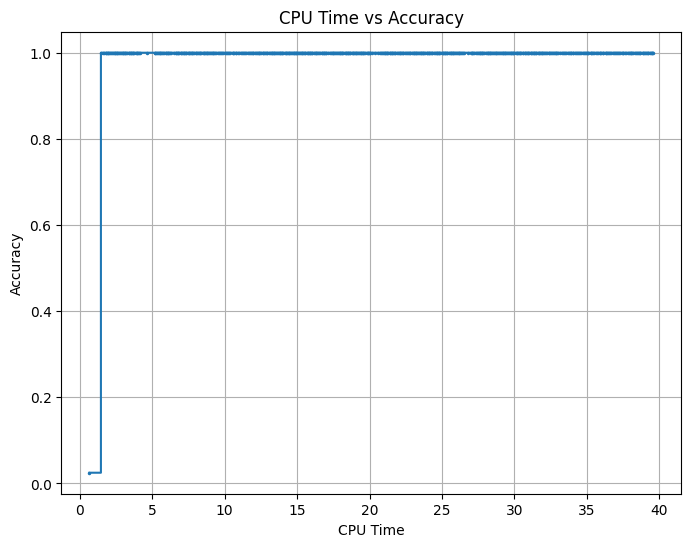

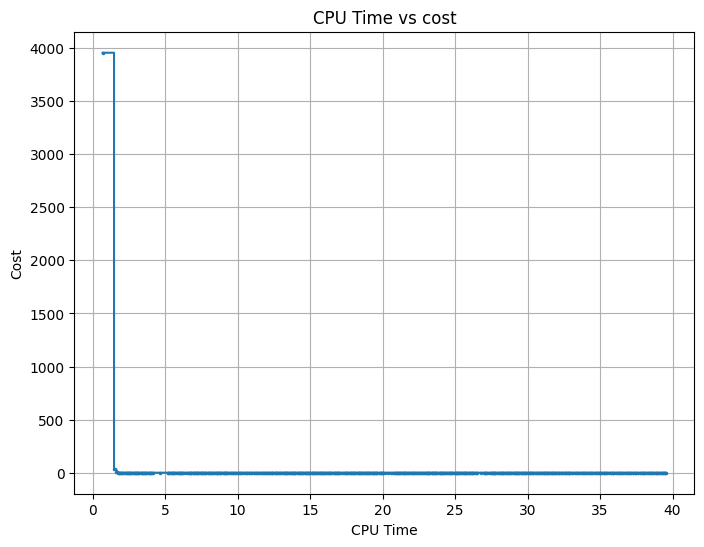

In [19]:
X, cputime_elapsed, accuracy_train, costs, real_time_elapsed = gradient_descent_armijo(A, b, k=50, plots=True, train_time=5)

We now move on with the implementation of Block Coordinate Gradient Descent, with GS rule. We implement it both with a fixed stepsize and using armijo rule

In [20]:
def BCGD_GS(A, B, k, lr=0.01, max_epochs=2000, plots=False, train_time = 30):
    start_t = time.time()
    start_cputime = time.process_time()

    # random seed
    t = 1000 * time.time() # current time in milliseconds
    np.random.seed = int(t) % 2**32
    # k is the number of classes, m is the number of training examples, d is the number of features
    m, d = A.shape
    # initialize weights to zero
    X = np.random.normal(0, 1, size=(d, k)) * 0.01
    I = one_hot_encode(k, B)

    cputime_elapsed = []
    real_time_elapsed = []
    accuracy_train = []
    costs = []

    epoch = 0

    while time.time() - start_t < train_time:
        
        AX, AX_exp, sum_AX_exp, norm_AX_exp = matrix_operations(A, X)
        
        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp))
        predictions = np.argmax(norm_AX_exp, axis=1) # compute prediction
        cputime_elapsed.append(time.process_time() - start_cputime)
        real_time_elapsed.append(time.time() - start_t)
        costs.append(cost)
        accuracy_train.append(compute_accuracy(predictions, B)) # compute accuracy

        Inorm = I - norm_AX_exp                               # prepare softmax matrix for gradient computation by subtracting it from OneHot matrix of labels
        grad = -np.matmul(A.T, Inorm)                       # compute gradient as matrix multimplication

        # compute the index of the block with highest gradient norm 1 value, we use this to update the parameters
        row_norm = np.sum(np.abs(grad), axis=1)
        idx_block = np.argmax(row_norm)
        X[idx_block] = X[idx_block] - (lr * grad[idx_block])

        epoch += 1

        # print("epoch: ", epoch, "\t\tcost: ", cost, "\t\taccuracy test: ", accuracy_train[-1])

    end_cputime = time.process_time()
    cpu_time = end_cputime - start_cputime
    finish_t = time.time()
    t = finish_t - start_t

    if plots == True:
        plot_accuracy(cputime_elapsed, accuracy_train)
        plot_cost(cputime_elapsed, costs)

    return X, cputime_elapsed, accuracy_train, costs, real_time_elapsed


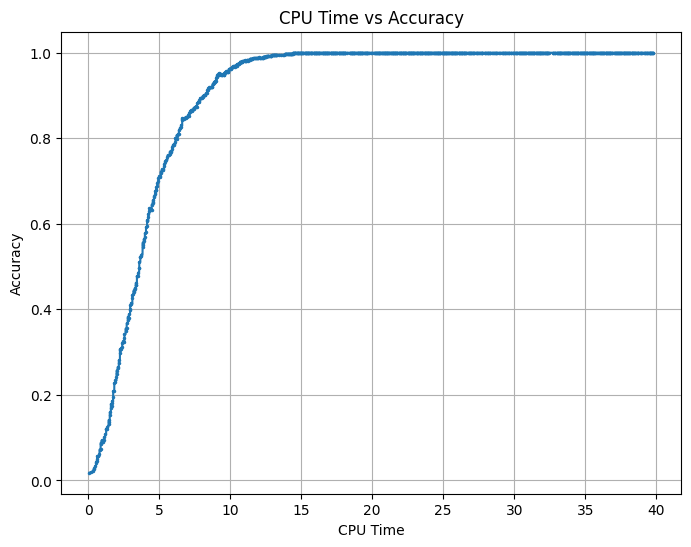

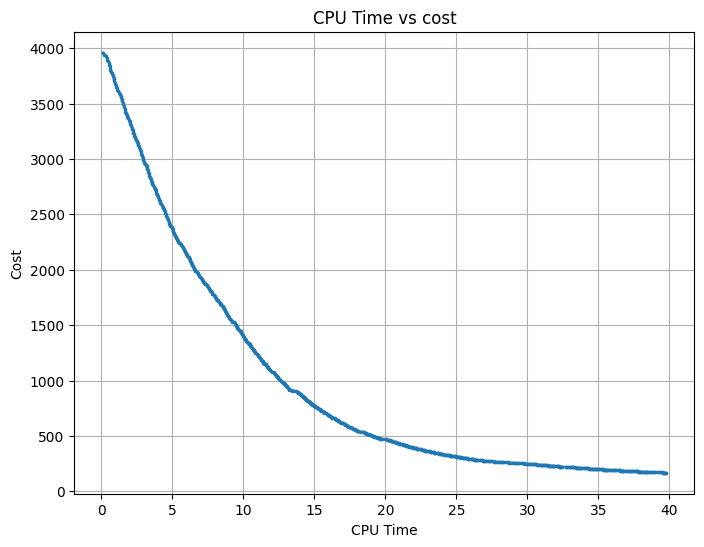

In [21]:
X, cputime_elapsed, accuracy_train, costs, real_time_elapsed = BCGD_GS(A, b, lr=0.01, k=50, plots=True, train_time=5)

In [22]:
def BCGD_GS_armijo(A, B, k, delta=0.1, gamma=0.0001, step=1, max_epochs=500, plots=False, train_time = 30, min_alpha=1e-20):
    start_t = time.time()
    start_cputime = time.process_time()

    # random seed
    t = 1000 * time.time() # current time in milliseconds
    np.random.seed = int(t) % 2**32
    # k is the number of classes, m is the number of training examples, d is the number of features
    m, d = A.shape
    # initialize weights to zero
    X = np.random.normal(0, 1, size=(d, k)) * 0.01
    I = one_hot_encode(k, B)

    cputime_elapsed = []
    accuracy_train = []
    costs = []
    real_time_elapsed = []

    epoch = 0

    while time.time() - start_t < train_time:

        AX, AX_exp, sum_AX_exp, norm_AX_exp = matrix_operations(A, X)
        
        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp))
        predictions = np.argmax(norm_AX_exp, axis=1) # compute prediction
        cputime_elapsed.append(time.process_time() - start_cputime)
        real_time_elapsed.append(time.time() - start_t)
        costs.append(cost)
        accuracy_train.append(compute_accuracy(predictions, B)) # compute accuracy

        Inorm = I - norm_AX_exp                             # prepare softmax matrix for gradient computation by subtracting it from OneHot matrix of labels
        grad = -np.matmul(A.T, Inorm)                       # compute gradient as matrix multimplication

        # compute the index of the block with highest gradient norm 1 value, we use this to update the parameters
        row_norm = np.sum(np.abs(grad), axis=1)
        idx_block = np.argmax(row_norm)

        # implement armijo
        iter = 0
        dk = -grad
        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp)) # cost function value of the CURRENT parameters

        while True:
            alpha = np.power(delta, iter) * step # stepsize computing

            if alpha < min_alpha:
                print("breaking to avoid infinite loop") # break condition to avoid infinite loop
                break
            
            X1 = X.copy()
            X1[idx_block] += alpha * dk[idx_block] # new parameters
            AX1, AX1_exp, sum_AX1_exp, norm_AX1_exp = matrix_operations(A, X1)

            cost1 = -np.sum(AX1[np.arange(m), B]) + np.sum(np.log(sum_AX1_exp)) # cost function for new parameters

            if cost1 <= cost + gamma * alpha * np.matmul(grad.flatten(), dk.flatten()): # if armjio condition is satisfied
                break
            iter += 1

        if alpha < min_alpha:
            break

        # print("alpha: ", alpha)
        X[idx_block] = X[idx_block] - (alpha * grad[idx_block])

        epoch += 1
        # print("epoch: ", epoch, "\t\tAvg cost: ", avg_cost, "\t\taccuracy test: ", compute_accuracy(predictions, B))

    end_cputime = time.process_time()
    cpu_time = end_cputime - start_cputime
    finish_t = time.time()
    t = finish_t - start_t

    if plots == True:
        plot_accuracy(cputime_elapsed, accuracy_train)
        plot_cost(cputime_elapsed, costs)

    return X, cputime_elapsed, accuracy_train, costs, real_time_elapsed




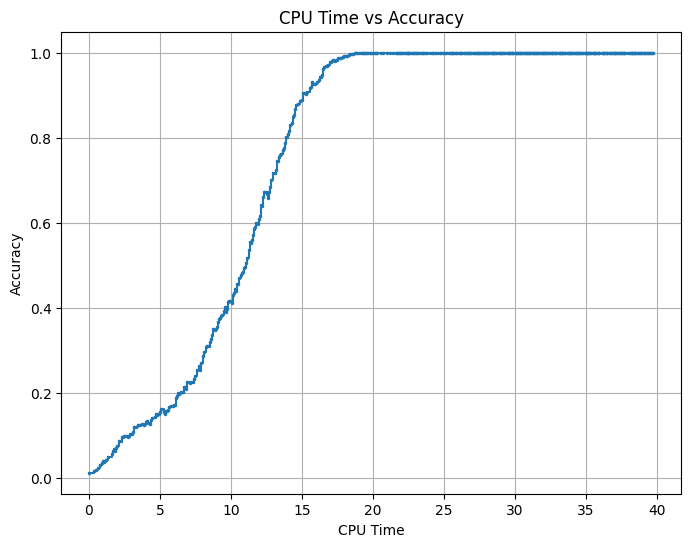

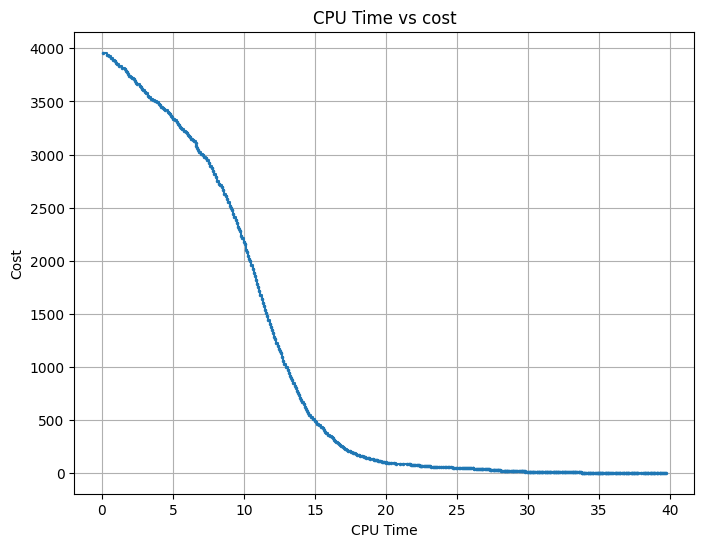

In [23]:
X, cputime_elapsed, accuracy_train, costs, real_time_elapsed = BCGD_GS_armijo(A, b, k = 50, plots=True, train_time = 5)

We also implemented BCGD with the randomized rule. Again we start with a simple fixed stepsize implementation and we move on with an armijo rule implementation

In [24]:
def BCGD_GS_rand(A, B, k, lr=0.01, max_epochs=2000, plots=False, train_time = 30):
    start_t = time.time()
    start_cputime = time.process_time()

    # random seed
    t = 1000 * time.time() # current time in milliseconds
    np.random.seed = int(t) % 2**32
    # k is the number of classes, m is the number of training examples, d is the number of features
    m, d = A.shape
    # initialize weights to zero
    X = np.random.normal(0, 1, size=(d, k)) * 0.01
    I = one_hot_encode(k, B)

    cputime_elapsed = []
    real_time_elapsed = []
    accuracy_train = []
    costs = []

    # number of blocks (in this case it's the same as m)
    n_blocks = X.shape[0]

    cost = float('inf')
    epoch = 0

    while time.time() - start_t < train_time:
        epoch += 1

        AX, AX_exp, sum_AX_exp, norm_AX_exp = matrix_operations(A, X)
        
        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp))
        predictions = np.argmax(norm_AX_exp, axis=1) # compute prediction
        cputime_elapsed.append(time.process_time() - start_cputime)
        real_time_elapsed.append(time.time() - start_t)
        costs.append(cost)
        accuracy_train.append(compute_accuracy(predictions, B)) # compute accuracy

        Inorm = I - norm_AX_exp                               # prepare softmax matrix for gradient computation by subtracting it from OneHot matrix of labels
        grad = -np.matmul(A.T, Inorm)                       # compute gradient as matrix multimplication

        # compute the index of the block with highest gradient norm 1 value, we use this to update the parameters
        idx_block = np.random.randint(0, n_blocks)
        X[idx_block] = X[idx_block] - (lr * grad[idx_block])

        # print("epoch: ", epoch, "\t\tcost: ", cost, "\t\taccuracy test: ", accuracy_train[-1])

    end_cputime = time.process_time()
    cpu_time = end_cputime - start_cputime
    finish_t = time.time()
    t = finish_t - start_t

    if plots == True:
        plot_accuracy(cputime_elapsed, accuracy_train)
        plot_cost(cputime_elapsed, costs)

    return X, cputime_elapsed, accuracy_train, costs, real_time_elapsed


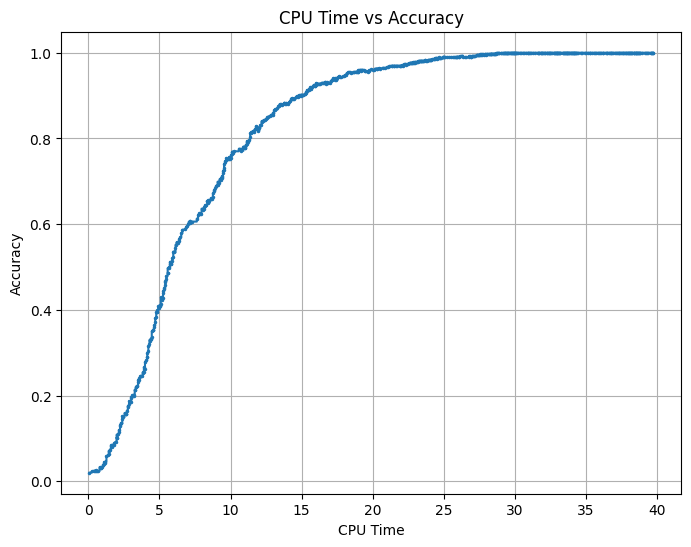

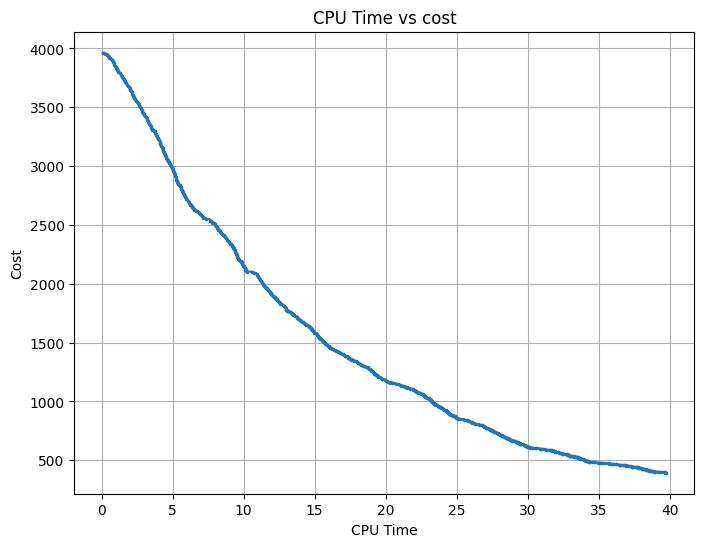

In [25]:
X, cputime_elapsed, accuracy_train, costs, real_time_elapsed = BCGD_GS_rand(A, b, k=50, plots=True, train_time=5)

In [26]:
def BCGD_GS_rand_armijo(A, B, k, delta=0.1, gamma=0.0001, step=1, max_epochs=500, plots=False, train_time = 30):
    start_t = time.time()
    start_cputime = time.process_time()

    # random seed
    t = 1000 * time.time() # current time in milliseconds
    np.random.seed = int(t) % 2**32
    # k is the number of classes, m is the number of training examples, d is the number of features
    m, d = A.shape
    # initialize weights to zero
    X = np.random.normal(0, 1, size=(d, k)) * 0.01
    I = one_hot_encode(k, B)

    cputime_elapsed = []
    accuracy_train = []
    costs = []
    real_time_elapsed = []

    # number of blocks (in this case it's the same as m)
    n_blocks = X.shape[0]

    avg_cost = float('inf')
    epoch = 0

    while time.time() - start_t < train_time:

        AX, AX_exp, sum_AX_exp, norm_AX_exp = matrix_operations(A, X)
        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp))
        predictions = np.argmax(norm_AX_exp, axis=1) # compute prediction
        cputime_elapsed.append(time.process_time() - start_cputime)
        real_time_elapsed.append(time.time() - start_t)
        costs.append(cost)
        accuracy_train.append(compute_accuracy(predictions, B)) # compute accuracy
        # print("epoch: ", epoch, "\t\tcost: ", cost, "\t\taccuracy test: ", accuracy_train[-1])

        Inorm = I - norm_AX_exp                             # prepare softmax matrix for gradient computation by subtracting it from OneHot matrix of labels
        grad = -np.matmul(A.T, Inorm)                       # compute gradient as matrix multimplicatio
        # compute the index of the block with highest gradient norm 1 value, we use this to update the parameters
        idx_block = np.random.randint(0, n_blocks)        # implement armijo

        iter = 0
        dk = -grad
        cost = -np.sum(AX[np.arange(m), B]) + np.sum(np.log(sum_AX_exp)) # cost function value of the CURRENT parameter
        while True:
            alpha = np.power(delta, iter) * step # stepsize computing
            X1 = X.copy()
            X1[idx_block] += alpha * dk[idx_block] # new parameters
            AX1, AX1_exp, sum_AX1_exp, norm_AX1_exp = matrix_operations(A, X1)
            cost1 = -np.sum(AX1[np.arange(m), B]) + np.sum(np.log(sum_AX1_exp)) # cost function for new parameter
            if cost1 <= cost + gamma * alpha * np.matmul(grad.flatten(), dk.flatten()): # if armjio condition is satisfied
                break
            iter += 1
        # print("alpha: ", alpha)
        X[idx_block] = X[idx_block] - (alpha * grad[idx_block])

        epoch += 1

    end_cputime = time.process_time()
    cpu_time = end_cputime - start_cputime
    finish_t = time.time()
    t = finish_t - start_t

    if plots == True:
        plot_accuracy(cputime_elapsed, accuracy_train)
        plot_cost(cputime_elapsed, costs)

    return X, cputime_elapsed, accuracy_train, costs, real_time_elapsed




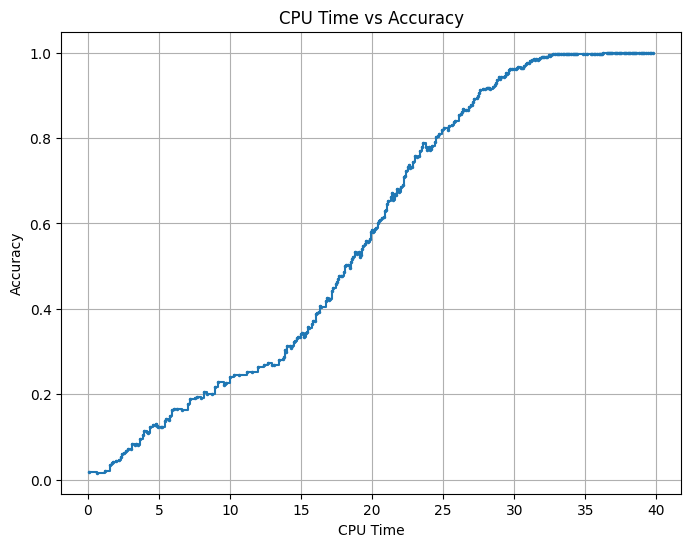

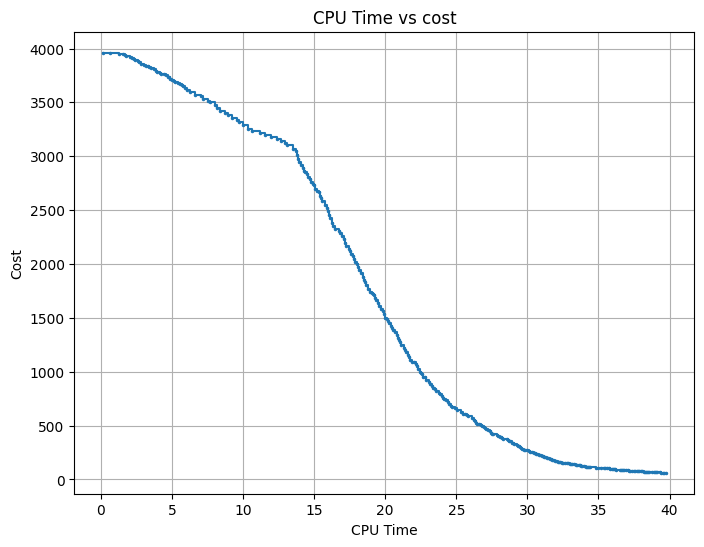

In [27]:
X, cputime_elapsed, accuracy_train, costs, real_time_elapsed = BCGD_GS_rand_armijo(A, b, k = 50, gamma=0.00001, plots=True, train_time = 5)

To better compare all the methods, we draw a plot that includes all results. The execution will take some time (based on train_t parameter), since every method has to run for a specified amount of time

In [28]:
methods_list = ["GD", "GD armijo", "BCGD", "BCGD armijo", "BCGD random", "BCGD random armijo"]

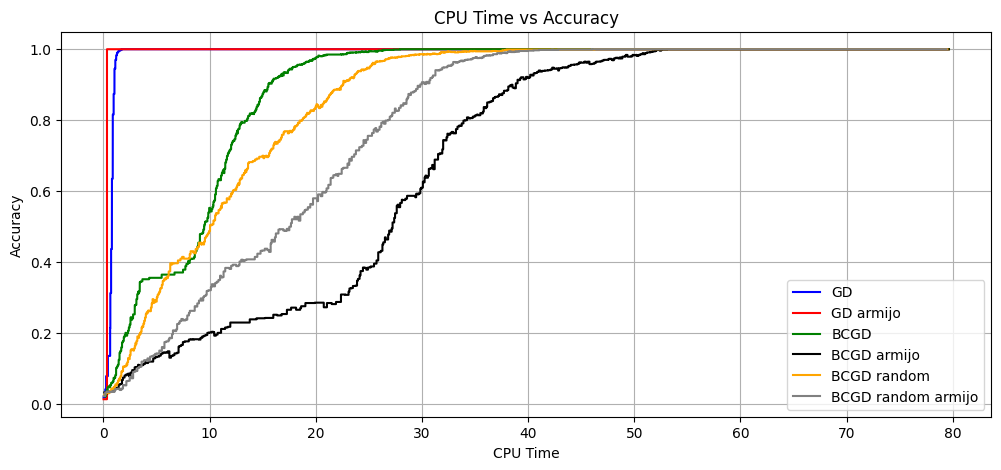

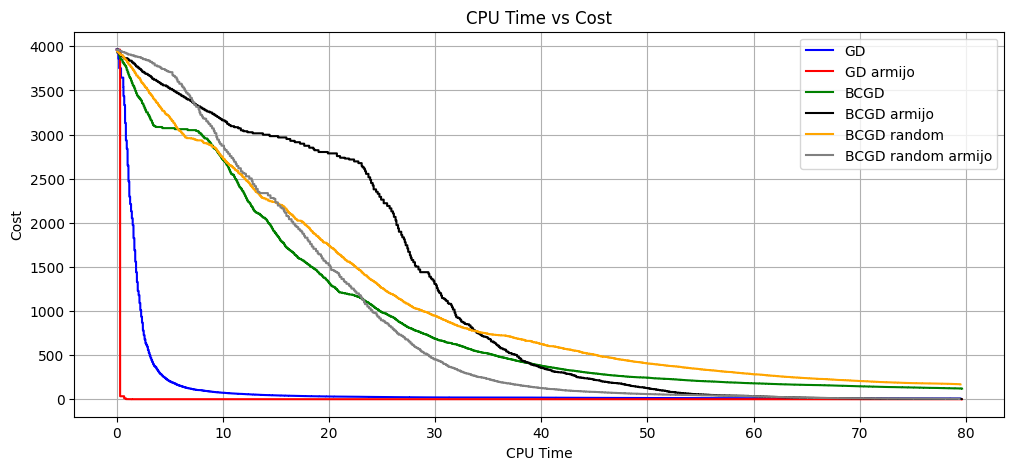

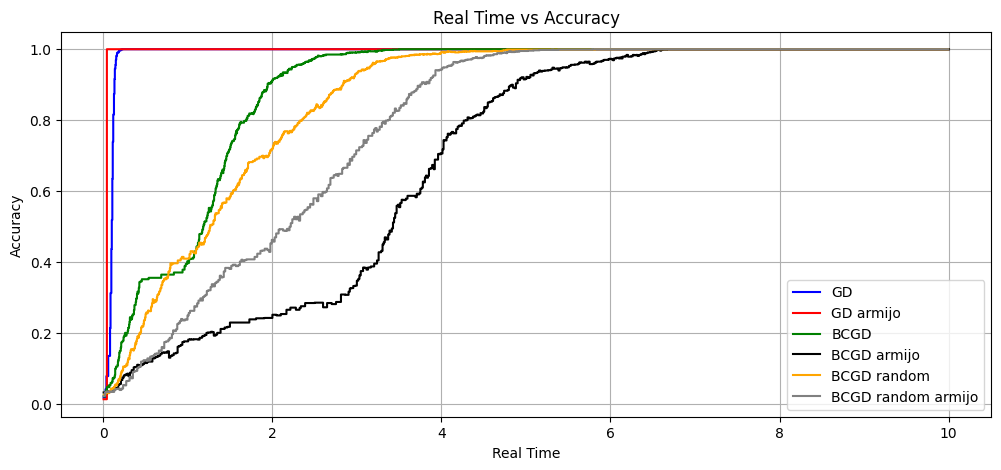

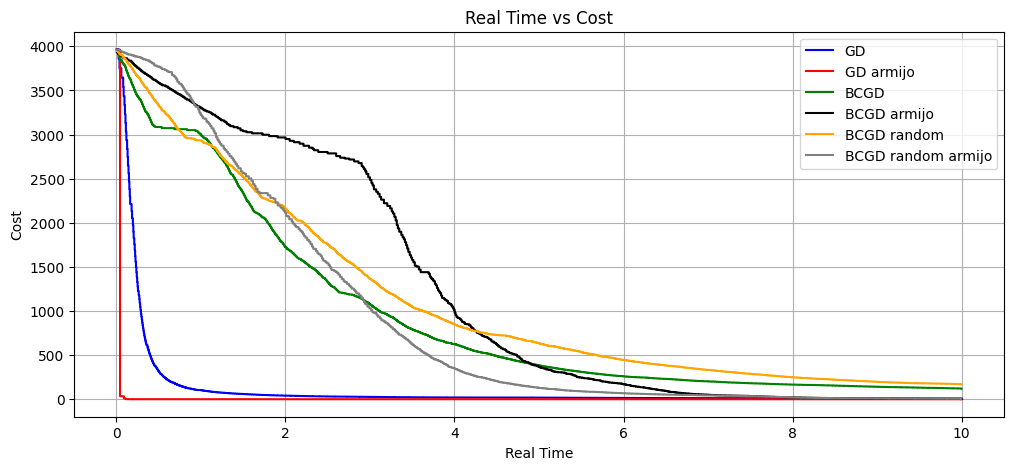

In [29]:
cputime_m = []
real_time_m = []
accuracy_m = []
costs_m = []
train_t = 10

X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = gradient_descent(A, b, k = 50, train_time = train_t, plots=False)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = gradient_descent_armijo(A, b, k=50, plots=False, train_time=train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS(A, b, k=50, plots=False, train_time=train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS_armijo(A, b, k = 50, plots=False, train_time = train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS_rand(A, b, k=50, plots=False, train_time=train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS_rand_armijo(A, b, k = 50, gamma=0.00001, plots=False, train_time = train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)

plot_all(cputime_m, real_time_m, accuracy_m, costs_m, methods_list)

for i, method in enumerate(methods_list):
    print(method, "\nCPU time:\t", cputime_m[i][-1], "\tAccuracy:\t", accuracy_m[i][-1], "\tcost:\t", costs_m[i][-1])

We now move to the analysis with real data. Our data come from the "Dry beans dataset", that can be found here: "https://www.muratkoklu.com/datasets/"

In [30]:
df = pd.read_csv('beans.csv', sep=';')

We start with some EDA

In [31]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,"610,291","208,1781167","173,888747","1,197191424","0,549812187",28715,"190,1410973","0,763922518","0,988855999","0,958027126","0,913357755","0,007331506","0,003147289","0,834222388","0,998723889",SEKER
1,28734,"638,018","200,5247957","182,7344194","1,097356461","0,411785251",29172,"191,2727505","0,783968133","0,984985603","0,887033637","0,953860842","0,006978659","0,003563624","0,909850506","0,998430331",SEKER
2,29380,"624,11","212,8261299","175,9311426","1,209712656","0,562727317",29690,"193,4109041","0,778113248","0,989558774","0,947849473","0,908774239","0,007243912","0,003047733","0,825870617","0,999066137",SEKER
3,30008,"645,884","210,557999","182,5165157","1,153638059","0,498615976",30724,"195,4670618","0,782681273","0,976695743","0,903936374","0,928328835","0,007016729","0,003214562","0,861794425","0,994198849",SEKER
4,30140,"620,134","201,8478822","190,2792788","1,06079802","0,333679658",30417,"195,896503","0,773098035","0,99089325","0,984877069","0,970515523","0,00669701","0,003664972","0,941900381","0,999166059",SEKER


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Area             13611 non-null  int64 
 1   Perimeter        13611 non-null  object
 2   MajorAxisLength  13611 non-null  object
 3   MinorAxisLength  13611 non-null  object
 4   AspectRation     13611 non-null  object
 5   Eccentricity     13611 non-null  object
 6   ConvexArea       13611 non-null  int64 
 7   EquivDiameter    13611 non-null  object
 8   Extent           13611 non-null  object
 9   Solidity         13611 non-null  object
 10  roundness        13611 non-null  object
 11  Compactness      13611 non-null  object
 12  ShapeFactor1     13611 non-null  object
 13  ShapeFactor2     13611 non-null  object
 14  ShapeFactor3     13611 non-null  object
 15  ShapeFactor4     13611 non-null  object
 16  Class            13611 non-null  object
dtypes: int64(2), object(15)
memory 

We notice that all variables have the same amount of measurements, so we don't need to delete any row. Float variables are of type "object", so we need to cast them. We also check for nan values

In [33]:
nan_values = df.isna().sum()
print("NaN values in each column:")
print(nan_values)

NaN values in each column:
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64


In [34]:
# change commas to points to allow cast to float
df = df.replace(',', '.', regex=True)

# cast to float of all object variables
for col in df:
    if col == 'Class':
        continue
    if df[col].dtype == 'object':
        df[col] = df[col].astype(float)

We made sure non nan values are present and we casted values to float. Now we isolate the target variable

In [35]:
target = df['Class']
df = df.drop('Class', axis=1)

We check the distribution of our data

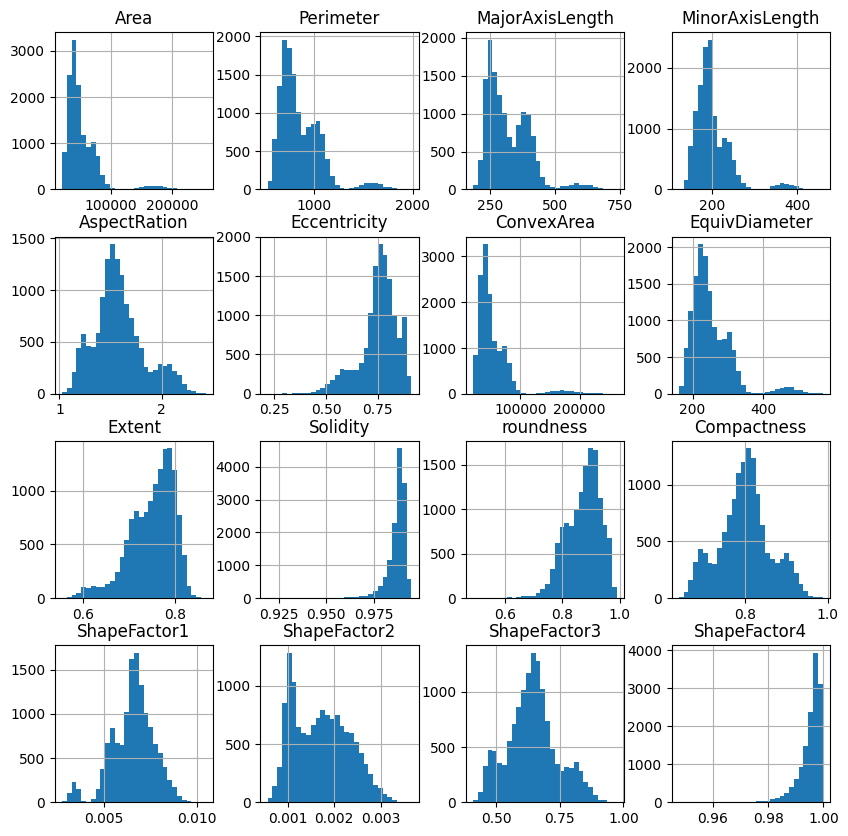

In [36]:
df.hist(bins=30, figsize=(10,10))
plt.show()

We notice there is probably a class that has very characteristc values in some features (like area and perimeter). We see that some features are noticeably multi-modal (like shape factor3). After some experimentation with outlier removal and other transformations of the data, we didn't get good improvements in our predictions. We therefore decided to keep all the examples. 

In [37]:
# number of classes
k = len(target.unique())
print(k)

7


In [38]:
target.value_counts()

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64

In [39]:
# we need to encode the target variable into integer values
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
target = labelencoder.fit_transform(target)

In [40]:
# now we can turn our df into a np matrix, we will use the same nomenclature as in the first part of the hw

A = df.values
b = target

We standardize the data. In this way we improve numerical stability when computing matrix operations in our algorithms

In [41]:
def standardize(A):
    means = np.mean(A, axis=0)
    stds = np.std(A, axis=0)
    A_std = (A - means) / stds
    return A_std

In [42]:
A_std = standardize(A)

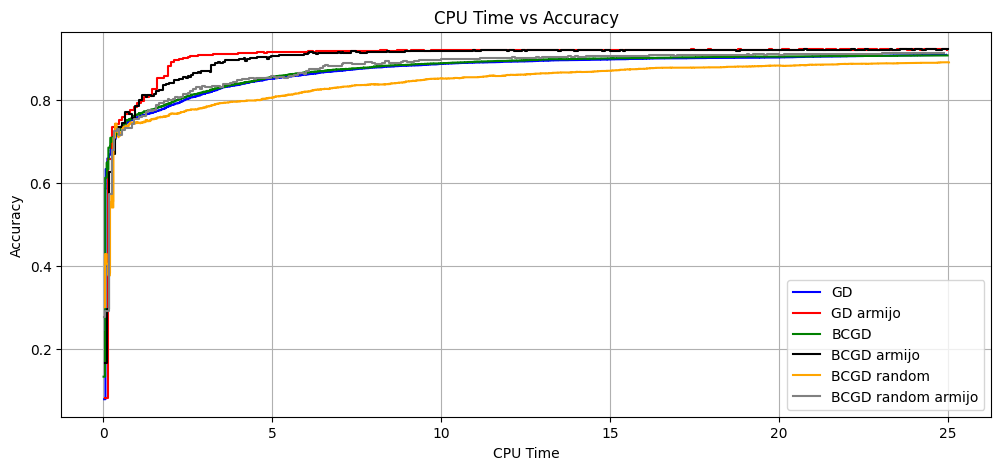

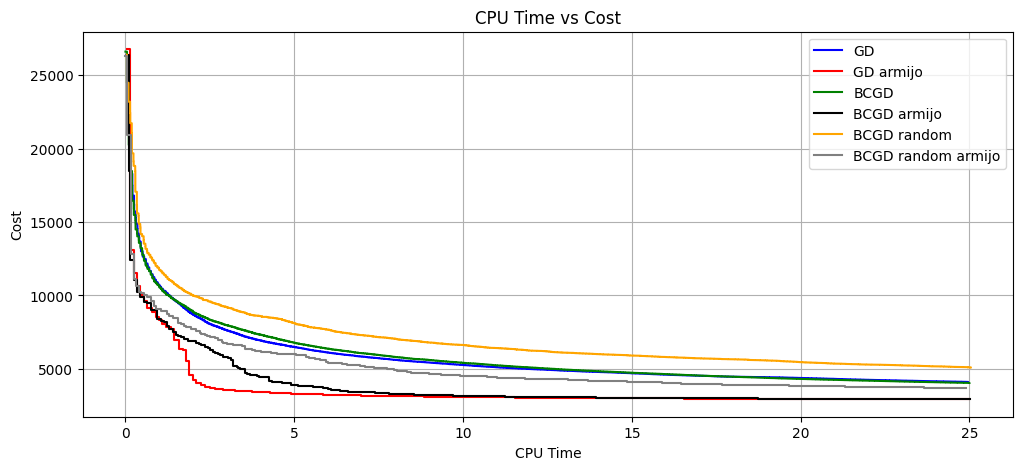

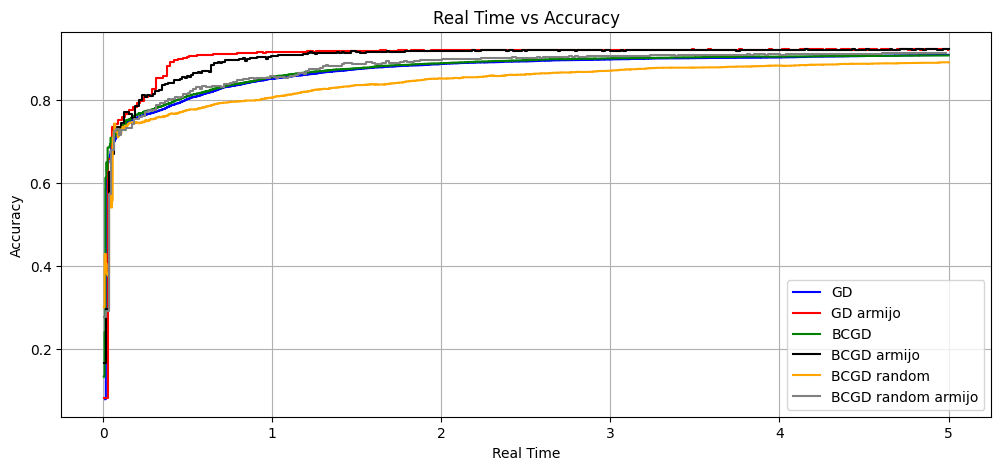

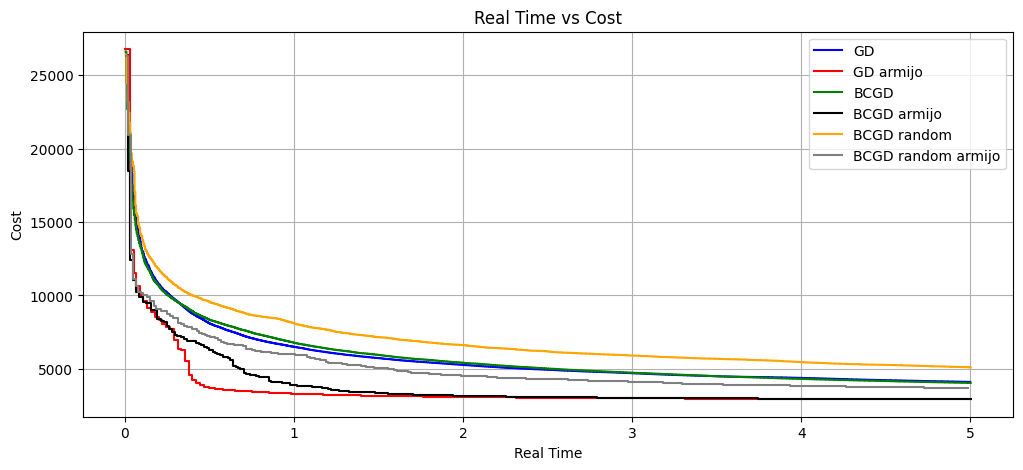

GD 
CPU time:	 24.962393399999996 	Accuracy:	 0.9095584453750643 	cost:	 4110.168994927516
GD armijo 
CPU time:	 24.99461640000004 	Accuracy:	 0.9224156931893321 	cost:	 2934.0726504188733
BCGD 
CPU time:	 25.001248900000064 	Accuracy:	 0.9082359855998825 	cost:	 4043.9952598036252
BCGD armijo 
CPU time:	 25.002973399999973 	Accuracy:	 0.9232238630519433 	cost:	 2936.8234699705863
BCGD random 
CPU time:	 25.042563200000018 	Accuracy:	 0.8917052384101095 	cost:	 5103.114067527062
BCGD random armijo 
CPU time:	 24.90795209999999 	Accuracy:	 0.91359929468812 	cost:	 3667.275526532572


In [43]:
cputime_m = []
accuracy_m = []
costs_m = []
real_time_m = []
train_t = 5

X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = gradient_descent(A_std, b, k=k, lr=0.00001, train_time = train_t, plots=False)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = gradient_descent_armijo(A_std, b, k=k, gamma=0.01, delta=0.1, plots=False, train_time=train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS(A_std, b, k=k, lr = 0.0001, plots=False, train_time=train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS_armijo(A_std, b, k=k, gamma=0.001, delta=0.1, step=0.1, plots=False, train_time = train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS_rand(A_std, b, k=k, lr = 0.0001, plots=False, train_time=train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)
X, cputime_elapsed, accuracy_train, cost, real_time_elapsed = BCGD_GS_rand_armijo(A_std, b, k=k, gamma=0.001, delta=0.1, step=0.1, plots=False, train_time = train_t)
cputime_m.append(cputime_elapsed)
accuracy_m.append(accuracy_train)
costs_m.append(cost)
real_time_m.append(real_time_elapsed)

plot_all(cputime_m, real_time_m, accuracy_m, costs_m, methods_list)

for i, method in enumerate(methods_list):
    print(method, "\nCPU time:\t", cputime_m[i][-1], "\tAccuracy:\t", accuracy_m[i][-1], "\tcost:\t", costs_m[i][-1])
